# Import libraries and dataset

In [539]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
import xgboost as xgb

from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_breast_cancer
from xgboost import XGBClassifier
import numpy as np

In [145]:
df = pd.read_csv('/Users/mananshah/Downloads/appdata10.csv')

In [146]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


In [147]:
df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

# Preprocessing the dataset

In [149]:
df['first_open'] = pd.to_datetime(df['first_open'])
df['enrolled_date'] = pd.to_datetime(df['enrolled_date'])

In [150]:
df['days_to_enroll'] = df['enrolled_date'] - df['first_open']

In [151]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,days_to_enroll
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaT,0,NaT
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaT,0,NaT
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaT,1,NaT
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0,0 days 00:03:03.159000
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1,0 days 00:05:49.180000


In [152]:
df.dtypes

user                              int64
first_open               datetime64[ns]
dayofweek                         int64
hour                             object
age                               int64
screen_list                      object
numscreens                        int64
minigame                          int64
used_premium_feature              int64
enrolled                          int64
enrolled_date            datetime64[ns]
liked                             int64
days_to_enroll          timedelta64[ns]
dtype: object

In [153]:
df['days_to_enroll'] = df['days_to_enroll'].dt.days

In [154]:
df.dtypes

user                             int64
first_open              datetime64[ns]
dayofweek                        int64
hour                            object
age                              int64
screen_list                     object
numscreens                       int64
minigame                         int64
used_premium_feature             int64
enrolled                         int64
enrolled_date           datetime64[ns]
liked                            int64
days_to_enroll                 float64
dtype: object

In [155]:
print('Minimum days to enroll are: ', str(df['days_to_enroll'].min()))
print('Maximum days to enroll are: ', str(df['days_to_enroll'].max()))

Minimum days to enroll are:  0.0
Maximum days to enroll are:  226.0


<Axes: >

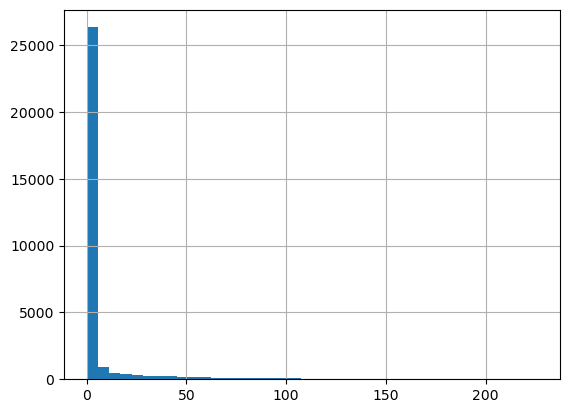

In [156]:
df['days_to_enroll'].hist(bins = 40)

In [157]:
df['upd_enroll'] = 0

In [158]:
#df.loc[(df['days_to_enroll']<61) & (df['enrolled'] == 1), 'upd_enroll'] = 1
df.upd_enroll = df.enrolled

In [159]:
# Check count of enrollment and non-enrollment in the dataset
df['upd_enroll'].value_counts()

upd_enroll
1    31074
0    18926
Name: count, dtype: int64

In [160]:
# Weekday or weekend does not impact
df.loc[:,['dayofweek', 'upd_enroll']].groupby(['dayofweek']).sum()

,upd_enroll
dayofweek,
0,4606
1,4315
2,3969
3,4258
4,4595
5,4685
6,4646


In [161]:
df.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked', 'days_to_enroll', 'upd_enroll'],
      dtype='object')

In [162]:
df.drop(columns = {'first_open', 'enrolled', 'enrolled_date', 'days_to_enroll'}, inplace = True)

In [163]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll
0,235136,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,0
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0
2,254414,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,1,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,0,1
4,51549,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,1


In [164]:
#df['screen_list'] = df.screen_list.astype(str) + ','

In [165]:
df_top_screen = pd.read_csv('/Users/mananshah/Downloads/top_screens.csv')
top_screen = np.array(df_top_screen.loc[:, 'top_screens'])

In [166]:
for i in top_screen:
    df[i] = df.screen_list.str.contains(i).astype(int)
    df['screen_list'] = df.screen_list.str.replace(i + ',', '')

In [167]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll,...,ProfileJobTitle,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker
0,235136,3,02:00:00,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,254414,1,19:00:00,23,Loan,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,ReferralCon...",40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,51549,1,18:00:00,31,"joinscreen,ScanPreview,VerifySSN,Home,SelectIn...",32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [168]:
df.columns

Index(['user', 'dayofweek', 'hour', 'age', 'screen_list', 'numscreens',
       'minigame', 'used_premium_feature', 'liked', 'upd_enroll', 'Loan2',
       'location', 'Institutions', 'Credit3Container', 'VerifyPhone',
       'BankVerification', 'VerifyDateOfBirth', 'ProfilePage', 'VerifyCountry',
       'Cycle', 'idscreen', 'Credit3Dashboard', 'Loan3', 'CC1Category',
       'Splash', 'Loan', 'CC1', 'RewardsContainer', 'Credit3', 'Credit1',
       'EditProfile', 'Credit2', 'Finances', 'CC3', 'Saving9', 'Saving1',
       'Alerts', 'Saving8', 'Saving10', 'Leaderboard', 'Saving4',
       'VerifyMobile', 'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'Saving7', 'ProfileEducationMajor', 'Rewards', 'AccountView',
       'VerifyAnnualIncome', 'VerifyIncomeType', 'Saving2', 'Saving6',
       'Saving2Amount', 'Saving5', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'L

In [169]:
df['non_top_screen_count'] = df.screen_list.str.count(',')

In [170]:
df.head()

,user,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,liked,upd_enroll,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,non_top_screen_count
0,235136,3,02:00:00,23,"joinscreen,product_review,ScanPreview,VerifyTo...",15,0,0,0,0,...,1,0,0,0,0,0,0,0,0,7
1,333588,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,254414,1,19:00:00,23,Loan,3,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,234192,4,16:00:00,28,"product_review,Home,product_review,ReferralCon...",40,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6
4,51549,1,18:00:00,31,"joinscreen,ScanPreview,VerifySSN,Home,SelectIn...",32,0,0,1,1,...,0,0,0,0,0,0,0,0,0,9


In [171]:
df.drop(columns = {'screen_list', 'user'}, inplace = True)

In [172]:
df['hour'] = [x[0:3] for x in df.hour]

In [173]:
df.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,upd_enroll,Loan2,location,...,Login,ProfileEmploymentLength,WebView,SecurityModal,Loan4,ResendToken,TransactionList,NetworkFailure,ListPicker,non_top_screen_count
0,3,02,23,15,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,7
1,6,01,24,13,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,5
2,1,19,23,3,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,16,28,40,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,6
4,1,18,31,32,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,9


In [174]:
df['hour'] = df['hour'].astype('int')

In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   dayofweek                50000 non-null  int64
 1   hour                     50000 non-null  int64
 2   age                      50000 non-null  int64
 3   numscreens               50000 non-null  int64
 4   minigame                 50000 non-null  int64
 5   used_premium_feature     50000 non-null  int64
 6   liked                    50000 non-null  int64
 7   upd_enroll               50000 non-null  int64
 8   Loan2                    50000 non-null  int64
 9   location                 50000 non-null  int64
 10  Institutions             50000 non-null  int64
 11  Credit3Container         50000 non-null  int64
 12  VerifyPhone              50000 non-null  int64
 13  BankVerification         50000 non-null  int64
 14  VerifyDateOfBirth        50000 non-null  int64
 15  Pr

In [176]:
savings_screens = ["Saving1", "Saving2", "Saving2Amount", "Saving4", "Saving5", "Saving6","Saving7", "Saving8", "Saving9", "Saving10"];
df['SavingCount']=df[savings_screens].sum(axis=1);
df.drop(columns=savings_screens,axis=1,inplace=True);
credit_screens = ["Credit1", "Credit2", "Credit3", "Credit3Container", "Credit3Dashboard"];
df['CreditCount']=df[credit_screens].sum(axis=1);
df.drop(columns=credit_screens,axis=1,inplace=True);
cc_screens = ["CC1", "CC1Category", "CC3"];
df['CCCount']=df[cc_screens].sum(axis=1);
df.drop(columns=cc_screens,axis=1,inplace=True);
loan_screens = ["Loan", "Loan2", "Loan3", "Loan4"];
df['LoanCount']=df[loan_screens].sum(axis=1);
df.drop(columns=loan_screens,axis=1,inplace=True);

In [177]:
df.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,liked,upd_enroll,location,Institutions,...,SecurityModal,ResendToken,TransactionList,NetworkFailure,ListPicker,non_top_screen_count,SavingCount,CreditCount,CCCount,LoanCount
0,3,2,23,15,0,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,1
1,6,1,24,13,0,0,0,0,1,1,...,0,0,0,0,0,5,0,0,0,2
2,1,19,23,3,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,16,28,40,0,0,0,1,1,0,...,0,0,0,0,0,6,0,3,0,1
4,1,18,31,32,0,0,1,1,0,1,...,0,0,0,0,0,9,0,2,0,1


In [178]:
df.columns

Index(['dayofweek', 'hour', 'age', 'numscreens', 'minigame',
       'used_premium_feature', 'liked', 'upd_enroll', 'location',
       'Institutions', 'VerifyPhone', 'BankVerification', 'VerifyDateOfBirth',
       'ProfilePage', 'VerifyCountry', 'Cycle', 'idscreen', 'Splash',
       'RewardsContainer', 'EditProfile', 'Finances', 'Alerts', 'Leaderboard',
       'VerifyMobile', 'VerifyHousing', 'RewardDetail', 'VerifyHousingAmount',
       'ProfileMaritalStatus', 'ProfileChildren ', 'ProfileEducation',
       'ProfileEducationMajor', 'Rewards', 'AccountView', 'VerifyAnnualIncome',
       'VerifyIncomeType', 'ProfileJobTitle', 'Login',
       'ProfileEmploymentLength', 'WebView', 'SecurityModal', 'ResendToken',
       'TransactionList', 'NetworkFailure', 'ListPicker',
       'non_top_screen_count', 'SavingCount', 'CreditCount', 'CCCount',
       'LoanCount'],
      dtype='object')

# EDA

/var/folders/lc/nt_cj8vj15b_73cwvpjjb5jm0000gn/T/ipykernel_36369/2169011760.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='upd_enroll', y='SavingCount', ci=None)


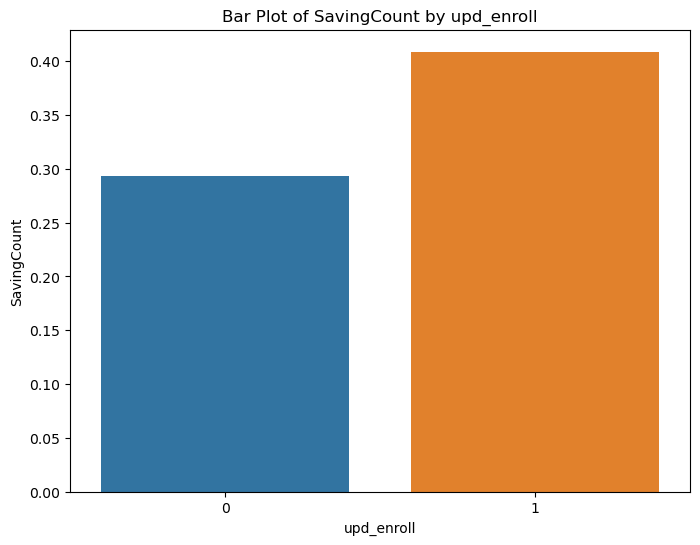

In [180]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='upd_enroll', y='SavingCount', ci=None)
plt.title('Bar Plot of SavingCount by upd_enroll')
plt.show()

/var/folders/lc/nt_cj8vj15b_73cwvpjjb5jm0000gn/T/ipykernel_36369/392818673.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='upd_enroll', y='CreditCount', ci=None)


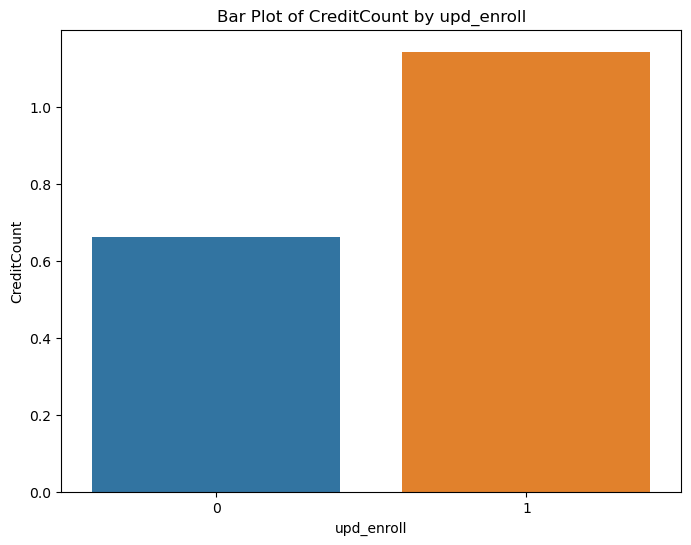

In [181]:
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='upd_enroll', y='CreditCount', ci=None)
plt.title('Bar Plot of CreditCount by upd_enroll')
plt.show()

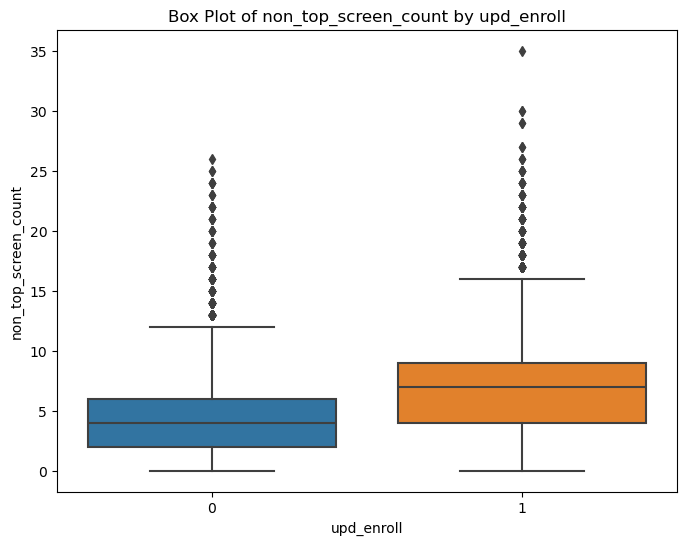

In [182]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='upd_enroll', y='non_top_screen_count')
plt.title('Box Plot of non_top_screen_count by upd_enroll')
plt.show()

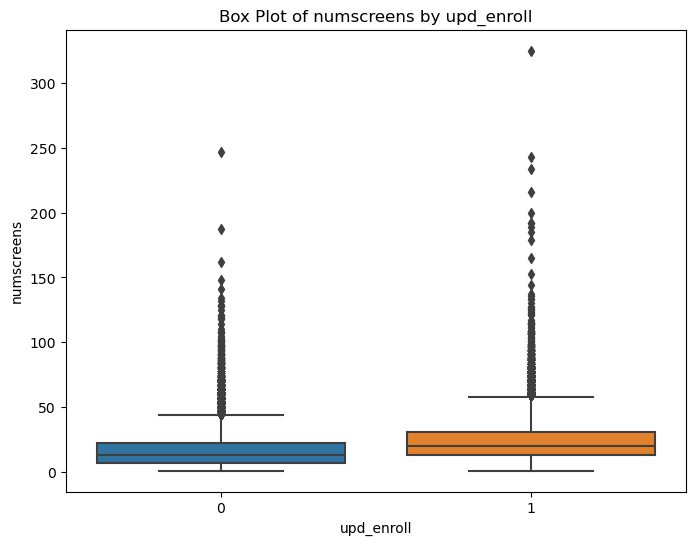

In [183]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='upd_enroll', y='numscreens')
plt.title('Box Plot of numscreens by upd_enroll')
plt.show()

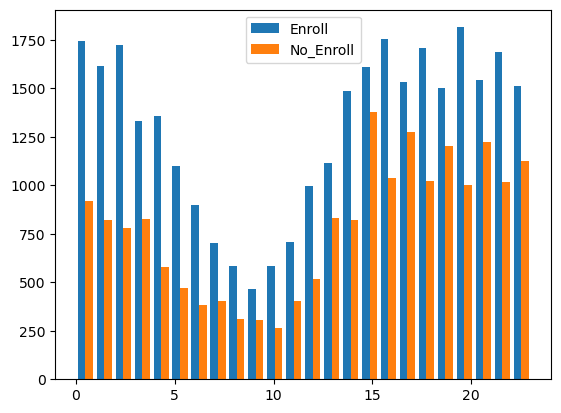

In [184]:
plt.hist([df.loc[df['upd_enroll']==1,:]['hour'], df.loc[df['upd_enroll']==0,:]['hour']],bins = 24)
plt.legend(['Enroll', 'No_Enroll'])

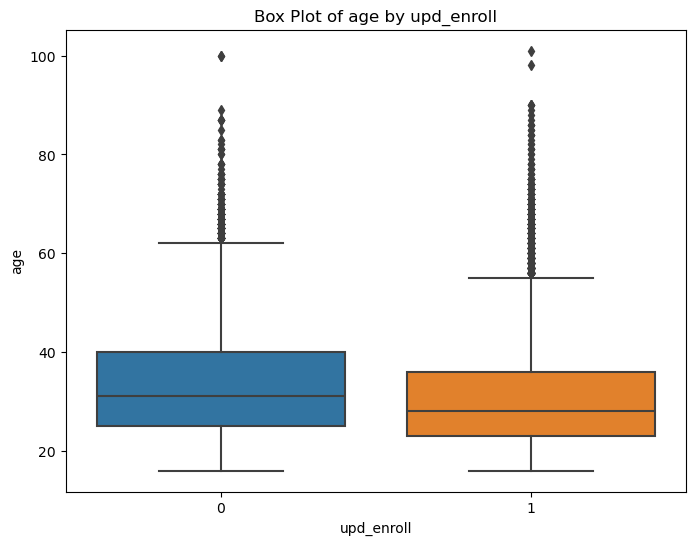

In [185]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='upd_enroll', y='age')
plt.title('Box Plot of age by upd_enroll')
plt.show()

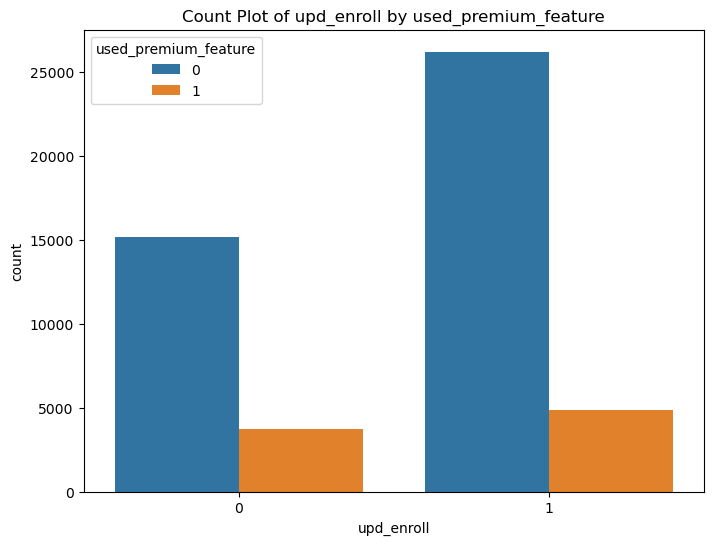

In [186]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='upd_enroll', hue='used_premium_feature')
plt.title('Count Plot of upd_enroll by used_premium_feature')
plt.show()

# Create training and testing dataset

In [188]:
# Creating input dataset
X = df.drop(['upd_enroll'],axis = 1)

In [189]:
# Creating output dataset
y = df['upd_enroll']

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_Scaled = pd.DataFrame(scale(X_train), columns = X_train.columns)
X_test_Scaled = pd.DataFrame(scale(X_test), columns = X_test.columns)

# XGBoost Model

In [528]:
# best_params_bayes = {'objective':'binary:logistic',
#                      'colsample_bytree': 0.7043167722693142, 
#                      'learning_rate': 0.04798936712593531, 
#                      'max_depth': 9, 
#                      'n_estimators': 164, 
#                      'reg_alpha': 5.851731127352833, 
#                      'reg_lambda': 0.8917491195675415, 
#                      'subsample': 0.8710496159306349
#                     }

# best_params_scikit = {'objective':'binary:logistic',
#                      'learning_rate': 0.01,
#                      'max_depth': 10,
#                      'n_estimators': 292,
#                      'subsample': 0.5,
#                      'colsample_bytree': 0.8167512066357197,
#                      'reg_lambda': 0.7234512950940174,
#                      'reg_alpha': 0.001
#                     }

# best_params_bayes = {'objective':'binary:logistic',
#                      'colsample_bytree': 0.5936477395867823, 
#                      'learning_rate': 0.10353399325047952, 
#                      'max_depth': 8, 
#                      'n_estimators': 78, 
#                      'reg_alpha': 1.4082293903581935, 
#                      'reg_lambda': 4.816610468498162, 
#                      'subsample': 0.901849492255092}


params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 1,
            'learning_rate': 1.0,
            'n_estimators':100
        }  

model = XGBClassifier(**params)
model.fit(X_train_Scaled, y_train)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [530]:
y_pred = model.predict(X_test_Scaled)

Accuracy = 0.73
Recall = 0.83
Precision = 0.75


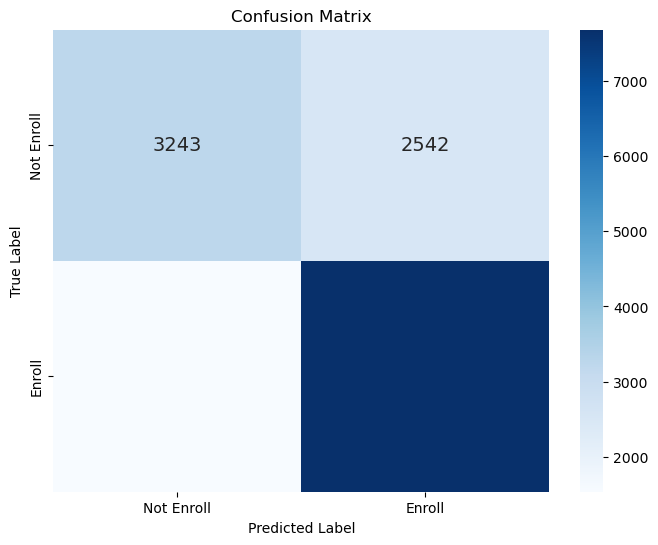

In [532]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}')
cm = confusion_matrix(y_test, y_pred)
#plt.figure()
#plt.title('Confusion Matrix on entire dataset')
#sns.heatmap(cm, annot = True)


#cm = confusion_matrix(y_true, y_pred)
classes = ['Not Enroll', 'Enroll']  # Class names

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [534]:
cm

array([[3243, 2542],
       [1537, 7678]])

In [536]:
import sklearn.metrics as metrics
print(metrics.roc_auc_score(y_test, y_pred))

0.6968972275202348


## XGBoost with Bayesian Hyperparameter Tuning

In [541]:
# Define Objective Function for Bayesian Optimization
def xgb_evaluate(learning_rate, max_depth, n_estimators, subsample, colsample_bytree, reg_lambda, reg_alpha):
    # Instantiate the XGBoost Model
    model = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=int(max_depth),  # Convert float to int
        n_estimators=int(n_estimators),  # Convert float to int
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        #use_label_encoder=False,
        eval_metric="logloss"
    )
    
    # Perform Cross-Validation
    #return accuracy_score(y_test, y_pred)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    return scores.mean()

# Define the Hyperparameter Bounds
param_bounds = {
    "learning_rate": (0.01, 0.3),
    "max_depth": (3, 10),
    "n_estimators": (50, 300),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "reg_lambda": (1e-3, 10.0),
    "reg_alpha": (1e-3, 10.0)
}

# Create Bayesian Optimization Object
optimizer = BayesianOptimization(
    f=xgb_evaluate,       # Objective function
    pbounds=param_bounds, # Parameter bounds
    random_state=42,      # Random seed
    verbose=2             # Output progress
)

# Run Optimization
optimizer.maximize(init_points=10, n_iter=40)

# Best Parameters
print("Best Parameters:", optimizer.max["params"])
print("Best Accuracy:", optimizer.max["target"])


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.7657    | 0.6873    | 0.2857    | 8.124     | 199.7     | 1.561     | 1.561     | 0.529     |
| 2         | 0.7839    | 0.9331    | 0.1843    | 7.957     | 55.15     | 9.699     | 8.325     | 0.6062    |
| 3         | 0.7853    | 0.5909    | 0.06319   | 5.13      | 181.2     | 4.32      | 2.913     | 0.8059    |
| 4         | 0.7861    | 0.5697    | 0.09472   | 5.565     | 164.0     | 7.852     | 1.998     | 0.7571    |
| 5         | 0.7783    | 0.7962    | 0.02347   | 7.253     | 92.63     | 0.6515    | 9.489     | 0.9828    |
| 6         | 0.7829    | 0.9042    | 0.09834   | 3.684     | 221.1     | 4.402     | 1.221     | 0.7476    |
| 7         | 0.784     | 0.5172    | 0.2737    | 4.811     | 215.6     | 3.118     | 5.201     | 0.7734    |
| 8       

In [547]:


bayes_opt_params= {'objective':'binary:logistic',
                  'colsample_bytree': 0.7043167722693142, 
                  'learning_rate': 0.04798936712593531, 
                  'max_depth': 9, 
                  'n_estimators': 164, 
                  'reg_alpha': 5.851731127352833, 
                  'reg_lambda': 0.8917491195675415, 
                  'subsample': 0.8710496159306349
                 }

model = XGBClassifier(**bayes_opt_params)
model.fit(X_train_Scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7043167722693142, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04798936712593531,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=164, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [549]:
y_pred = model.predict(X_test_Scaled)

Accuracy = 0.75
Recall = 0.86
Precision = 0.76


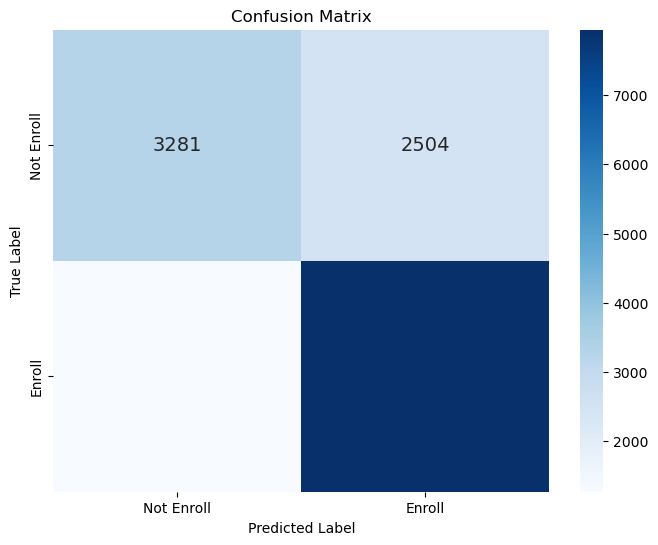

In [551]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score

print(f'Accuracy = {accuracy_score(y_test, y_pred):.2f}\nRecall = {recall_score(y_test, y_pred):.2f}\nPrecision = {precision_score(y_test, y_pred):.2f}')
cm = confusion_matrix(y_test, y_pred)


#cm = confusion_matrix(y_true, y_pred)
classes = ['Not Enroll', 'Enroll']  # Class names

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, annot_kws={"size": 14})
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [553]:
import sklearn.metrics as metrics
print(metrics.roc_auc_score(y_test, y_pred))

0.7146688326640407


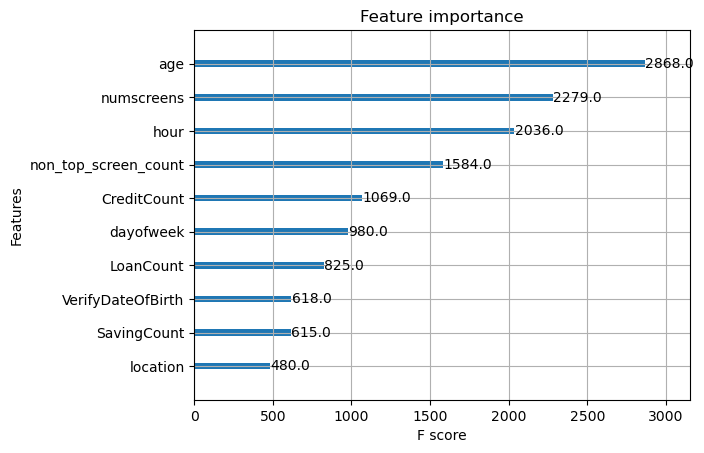

<Figure size 2000x2000 with 0 Axes>

In [555]:

xgb.plot_importance(model, max_num_features=10)
plt.figure(figsize = (20, 20))
plt.show()

In [557]:
y_pred_train = model.predict(X_train_Scaled)

In [559]:
print(f'Accuracy = {accuracy_score(y_train, y_pred_train):.2f}\nRecall = {recall_score(y_train, y_pred_train):.2f}\nPrecision = {precision_score(y_train, y_pred_train):.2f}')

Accuracy = 0.82
Recall = 0.87
Precision = 0.85


In [561]:
print (metrics.roc_auc_score(y_train,y_pred_train))

0.8030277596778287
